In [1]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler,DDPMPipeline,UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda', index=0)

In [4]:
# 加载MNIST数据集
dataset = torchvision.datasets.MNIST(
    root='./mnist', train=True, transform=torchvision.transforms.ToTensor(), download=True)

In [5]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels : tensor([9, 7, 9, 8, 2, 9, 1, 2])


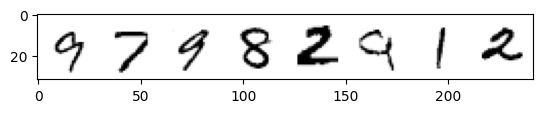

In [6]:
# 查看图像
x,y = next(iter(train_dataloader))
print("Input shape:",x.shape)
print("Labels :",y)
plt.imshow(torchvision.utils.make_grid(x)[0],cmap='Greys')

由于传统意义的UNet只能做到生成一张类似于输入集的图像，而无法生成一张具有类别或特殊标记意义的图像。  
因此，通过将类别与原始输入进行合并以告诉UNet生成器每一张图像所属的类别

In [7]:
class ClassConditionedUNet(nn.Module):
    # 其实，作为类别嵌入的大小，也可以使其与原始类别数量保持一致
    def __init__(self,num_classes=10,class_emd_size=4) -> None:
        super().__init__()
        self.class_emb = nn.Embedding(num_classes,class_emd_size)
        self.model = UNet2DModel(
            sample_size=28,
            in_channels=1 + class_emd_size, # 使其输入通道数为1+类别嵌入大小

            out_channels=1, # 由于MNIST是灰度图像，因此输出通道数为1
            layers_per_block=2,
            block_out_channels=(32,64,64),
            down_block_types=(
                "DownBlock2D",
                "AttnDownBlock2D",
                "AttnDownBlock2D"
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",
                "UpBlock2D"
            ),
        )
    def forward(self,x,t,class_labels):
        bs,ch,w,h = x.shape
        # 将类别信息进行嵌入
        class_cond = self.class_emb(class_labels)
        # 将类别信息进行扩展
        class_cond = class_cond.view(bs,class_cond.shape[1],1,1).expand(
            bs,class_cond.shape[1],w,h
        )
        net_input = torch.cat((x,class_cond),1)
        return self.model(net_input,t).sample

In [8]:
# 创建Pytorch Lightning模型
import pytorch_lightning as pl

In [20]:
from typing import Any

from pytorch_lightning.utilities.types import STEP_OUTPUT


class LightningModel(pl.LightningModule):
    def __init__(self,model):
        super().__init__()
        self.model = model.to(device)
        self.noise_scheduler = DDPMScheduler(
            num_train_timesteps=1000,
            beta_schedule="squaredcos_cap_v2"
        )
        self.loss_fn = nn.MSELoss()
        self.loss = None
        self.losses = []
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr=1e-3)
    def training_step(self,batch,batch_idx):
        x,y = batch
        noise = torch.randn_like(x)
        timesteps = torch.randint(0,999,(x.shape[0],),device=x.device).long()
        noisy_x = self.noise_scheduler.add_noise(x,noise,timesteps)
        pred = self.model(noisy_x,timesteps,y)
        self.loss = self.loss_fn(pred,x)
        self.losses.append(self.loss.item())
        self.loss.backward(self.loss)
        self.optimizer.step()
        self.optimizer.zero_grad()
    def configure_optimizers(self) -> Any:
        return self.optimizer   
    def plot_pred(self):
        x = torch.randn(80,1,28,28).to(device)
        y = torch.tensor([[i] * 8 for i in range(10)]).flatten().to(device)

        # 采样循环
        for i,t in tqdm(enumerate(self.noise_scheduler.timesteps)):
            with torch.no_grad():
                residual = self.model(x,t,y)
            x = self.noise_scheduler.step(
                residual,t,x
            )
        # 绘制结果
        fig,ax = plt.subplots(1,1,figsize=(12,12))
        ax.imshow(
            torchvision.utils.make_grid(x.detach().cpu().clip(-1,1),nrow=8)[0],cmap='Greys'
        )

In [23]:
# 创建Trainer
trainer = pl.Trainer(
    accumulate_grad_batches=4,
    max_epochs=5,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [24]:
torch.set_float32_matmul_precision('medium')

In [25]:
# 创建模型
model = ClassConditionedUNet().to(device)
lightning_model = LightningModel(model)
# 训练模型
trainer.fit(lightning_model,train_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                 | Params
-------------------------------------------------
0 | model   | ClassConditionedUNet | 1.7 M 
1 | loss_fn | MSELoss              | 0     
-------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.833     Total estimated model params size (MB)
/root/anaconda3/envs/hugging/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


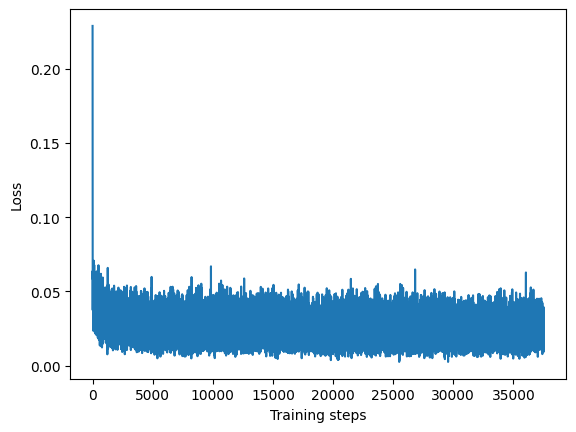

In [26]:
plt.plot(lightning_model.losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

In [27]:
lightning_model.plot_pred()

0it [00:00, ?it/s]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)